In [1]:
%load_ext autoreload
%autoreload 2

## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

In [2]:
from pathlib import Path

import torch
from hydra import initialize, compose

from neural_jacobian_field.config.common import get_typed_root_config, PipelineCfg
from neural_jacobian_field.data.data_module import DATASETS
from neural_jacobian_field.data.dataset.dataset import DatasetItems
from neural_jacobian_field.models.model import (
    Model,
    CameraInput,
    RenderingInput,
    RobotInput,
)
from neural_jacobian_field.models.model_wrapper import ModelWrapper
from neural_jacobian_field.rendering import geometry
from neural_jacobian_field.utils import convention
from neural_jacobian_field.utils.wandb_ckpt import update_checkpoint_path

In [ ]:
from neural_jacobian_field.data.data_module import DatasetCommon

model_name = "model_toy_arm"
dataset_name = "dataset_toy_arm"
action_decoder_name = "jacobian_mlp"
checkpoint_path = "./inference_demo_data/real_world_pretrained_ckpts/m8bmmdnk/model.ckpt"

config_path = Path("project/neural_jacobian_field/configurations/config")

dataset_config_path = Path("./dataset_configs/toy_arm_config.json")

overrides = [
    f"model={model_name}",
    f"dataset={dataset_name}",
    f"dataset.root={dataset_config_path}",
    f"model.action_decoder.name={action_decoder_name}",
    f"model.rendering.num_proposal_samples=[256]",
    f"model.rendering.num_nerf_samples=256",
]

map_to_root = Path("../../")
with initialize(version_base=None, config_path=str(map_to_root / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

dataset: DatasetCommon = DATASETS[cfg.dataset.name](cfg=cfg.dataset, stage="train")
model = Model(cfg.model)
wrapper = ModelWrapper(cfg=cfg, model=model)

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [17]:
checkpoint = torch.load(checkpoint_path)

wrapper.load_state_dict(checkpoint["state_dict"])
wrapper.eval()

ModelWrapper(
  (model): Model(
    (encoder): EncoderResnet(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

### Move to gpu and load near and far bounds

In [18]:
device = torch.device("cuda:0")

wrapper.to(device)
z_near = torch.tensor([dataset.near], device=device)
z_far = torch.tensor([dataset.far], device=device)
dataset_items: DatasetItems = dataset.dataset_items
ctxt_camera_index = 3
trgt_camera_index = 3


### Load camera data

In [19]:
ctxt_intrinsics, (render_height, render_width) = dataset.load_intrinsics(
    ctxt_camera_index
)
trgt_intrinsics, _ = dataset.load_intrinsics(trgt_camera_index)

ctxt_intrinsics = ctxt_intrinsics.to(device)
trgt_intrinsics = trgt_intrinsics.to(device)

ctxt_extrinsics = dataset.load_extrinsics(ctxt_camera_index).to(device)
trgt_extrinsics = dataset.load_extrinsics(trgt_camera_index).to(device)

ctxt_extrinsics, trgt_extrinsics = dataset.get_relative_transform(
    ctxt_extrinsics, trgt_extrinsics
)
coordinates, _ = geometry.get_pixel_coordinates(
    height=render_height, width=render_width, device=device
)

ctxt_extrinsics = ctxt_extrinsics.unsqueeze(0)
trgt_extrinsics = trgt_extrinsics.unsqueeze(0)

ctxt_intrinsics = ctxt_intrinsics.unsqueeze(0)
trgt_intrinsics = trgt_intrinsics.unsqueeze(0)

### Load example input image

In [20]:
from neural_jacobian_field.utils.io_utils import numpy_to_torch_image, load_numpy_image

image_filename = Path("./inference_demo_data/toy_arm_observation.png")
input_image_np = load_numpy_image(image_filename)
input_image_th = numpy_to_torch_image(input_image_np).to(device)[None]

print(input_image_th.shape)

torch.Size([1, 3, 480, 640])


In [21]:
image_height, image_width = input_image_th.shape[-2:]

origins, directions, z_values = geometry.get_world_rays_with_z(
    coordinates.view(1, -1, 2),
    trgt_intrinsics,
    trgt_extrinsics,
)

### Volume render the Jacobian Fields 

- This step is slow because of volume rendering. However, note that **volume rendering is only necessary for visualization purposes**. 
- For control purposes, gradient-based optimization of robot commands can be run at 12 hz and real-time if least square solver is used.


In [22]:
action_dim = model.decoder.action_dim
robot_action_th = torch.zeros((1, action_dim), device=device)

In [23]:
with torch.no_grad():
    rendering_outputs = model.patch_render(
        camera_input=CameraInput(
            input_image=input_image_th,
            ctxt_extrinsics=ctxt_extrinsics,
            ctxt_intrinsics=ctxt_intrinsics,
            trgt_extrinsics=trgt_extrinsics,
            trgt_intrinsics=convention.denormalize_intrinsics(
                trgt_intrinsics, width=image_width, height=image_height
            ),
        ),
        rendering_input=RenderingInput(
            origins=origins,
            directions=directions,
            z_near=z_near + torch.ones_like(z_near) * 0.15,
            z_far=torch.ones_like(z_far) * 3.2,
        ),
        robot_input=RobotInput(
            robot_action=robot_action_th,
        ),
        verbose=True,
    )

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:15<00:00,  9.56it/s]


### Visualize the Jacobian Image 

- After volume rendering, the Jacobian image is of shape `H x W x Spatial Dim x Action Dim`. In this case spatial dim is projected from three dimensions to two dimensions.
- We compute norm over the spatial dimension to get a measurement of how sensitive each pixel is w.r.t each robot command channel.


In [24]:
from neural_jacobian_field.inference.jacobian_color_map import (
    JACOBIAN_COLORMAP,
    visualize_joint_sensitivity,
    visualize_jacobian_chain_structure,
    compute_joint_sensitivity,
)

joint_sensitivity_th = compute_joint_sensitivity(
    jacobians=rendering_outputs.action_features, extrinsics=trgt_extrinsics
)

print(rendering_outputs.action_features.shape)
print(joint_sensitivity_th.shape)

torch.Size([1, 480, 640, 18])
torch.Size([1, 6, 480, 640])


### Visualize the Jacobian Image 

- For every command channel, for visualization purpose, we assign a color component for that channel. `JACOBIAN_COLORMAP`
- We now can convert the sensitvity image to a meaningful visualization of how sensitive pixel is for a command channel. 

### Special notes for visualizing the toy arm

- Because the toy robot arm has a kinematic chain structure, to create a clear visualization we start from the root joint in the kinematic tree and overlay later joint's influence on top of the previous ones. 
- This creates an overlaid pattern that is easily understandable to human eyes. Note that this expert knowledge is only required for visualization, not control purposes.

In [25]:
jacobian_colormap = torch.tensor(
    JACOBIAN_COLORMAP[model_name], device=device, dtype=torch.float32
).T

jacobian_colormap = 1 - jacobian_colormap

rendering_outputs.action_features.shape

torch.Size([1, 480, 640, 18])

(480, 640, 3)
(6, 480, 640)
torch.Size([3, 6])


""

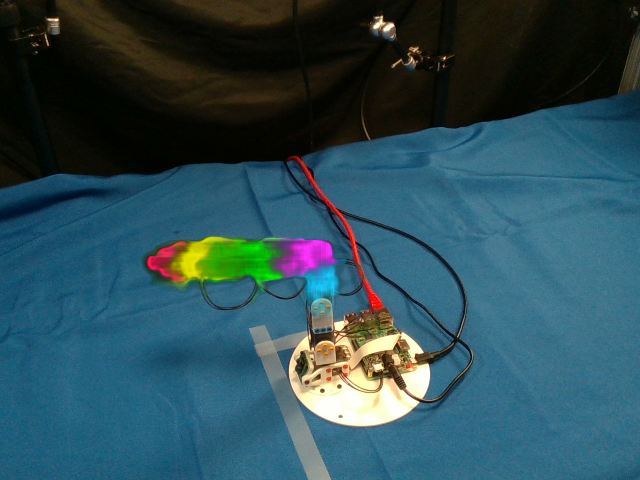

In [26]:
"""Visualize the jacobian chain structure"""
import mediapy as media

joint_sensitivity_np = joint_sensitivity_th.cpu().numpy()[0]

print(input_image_np.shape)
print(joint_sensitivity_np.shape)
print(jacobian_colormap.shape)

pred_jacobian_overlay_rgb, _ = visualize_jacobian_chain_structure(
    input_image_np=input_image_np,
    input_joint_sensitivity_np=joint_sensitivity_np,
    joint_colors_np=jacobian_colormap.cpu().numpy().T,
)
pred_jacobian_overlay_rgb = pred_jacobian_overlay_rgb[..., :3]

media.show_images(
 [
     pred_jacobian_overlay_rgb
 ]   
)